In [1]:
import numpy as np
import glob
from collections import Counter
import matplotlib.pyplot as plt
import os 

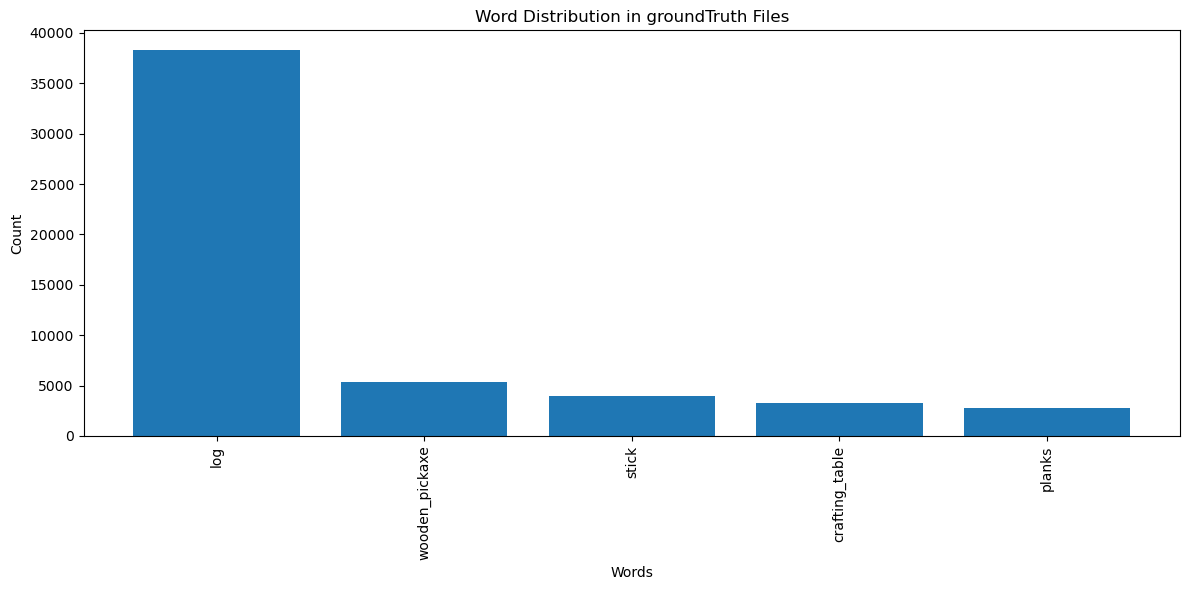

In [2]:
file_paths = glob.glob("Data/make_wooden_pickaxe/groundTruth/*")

# Step 2: Count all words across files
word_counter = Counter()

for file_path in file_paths:
    with open(file_path, 'r') as f:
        words = [line.strip() for line in f if line.strip()]
        word_counter.update(words)


# Step 3: Plot the distribution
words, counts = zip(*word_counter.most_common())  # sorted by frequency

plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Word Distribution in groundTruth Files")
plt.tight_layout()
plt.show()

In [3]:
numpy_files = glob.glob("Data/make_wooden_pickaxe/pixel_obs/*")

os.makedirs("Data/make_wooden_pickaxe/flattened_images", exist_ok=True)

all_data = []

for file_ in numpy_files:
    data = np.load(file_, allow_pickle=True)
    flattened_images = []
    for frame in data:
        img = frame['image']
        file_name = file_.split("/")[-1]
        img = img.flatten()
        flattened_images.append(img)
        all_data.append(img)
    
    flattened_images = np.array(flattened_images)
    np.save(f"Data/make_wooden_pickaxe/flattened_images/{file_name}", flattened_images)

In [4]:
#Run PCA on the all data array
from sklearn.decomposition import IncrementalPCA
pca = IncrementalPCA(n_components=1000)
batch_size = 5000

for i in range(0, len(all_data), batch_size):
    batch = all_data[i:i + batch_size]
    pca.partial_fit(batch)

print(f"Number of components to explain 99% of variance: {pca.n_components_}")

Number of components to explain 99% of variance: 1000


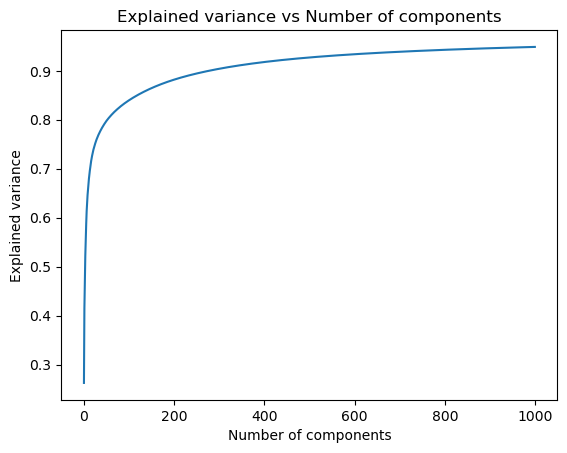

In [5]:
#Print the amount of variance captured:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance vs Number of components')
plt.show()

In [6]:
#Save the PCA model
import joblib
joblib.dump(pca, "Data/make_wooden_pickaxe/pca_model.pkl")

['Data/make_wooden_pickaxe/pca_model.pkl']

In [7]:
del all_data

In [8]:
numpy_files = glob.glob("Data/make_wooden_pickaxe/pixel_obs/*")

os.makedirs("Data/make_wooden_pickaxe/pca_features", exist_ok=True)


for file_ in numpy_files:
    data = np.load(file_, allow_pickle=True)
    flattened_images = []
    for frame in data:
        img = frame['image']
        file_name = file_.split("/")[-1]
        img = img.flatten()
        
        #Transform the image using the PCA model
        img = pca.transform([img])[0]
        flattened_images.append(img)

    flattened_images = np.array(flattened_images)
    np.save(f"Data/make_wooden_pickaxe/pca_features/{file_name}", flattened_images)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8.436933207434251..266.4301746769128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16.783017764149406..263.5850008362807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-23.509378643954967..272.1067020155089].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18.95782367642405..254.9972840256848].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6.28809017236042..257.76744197141323].


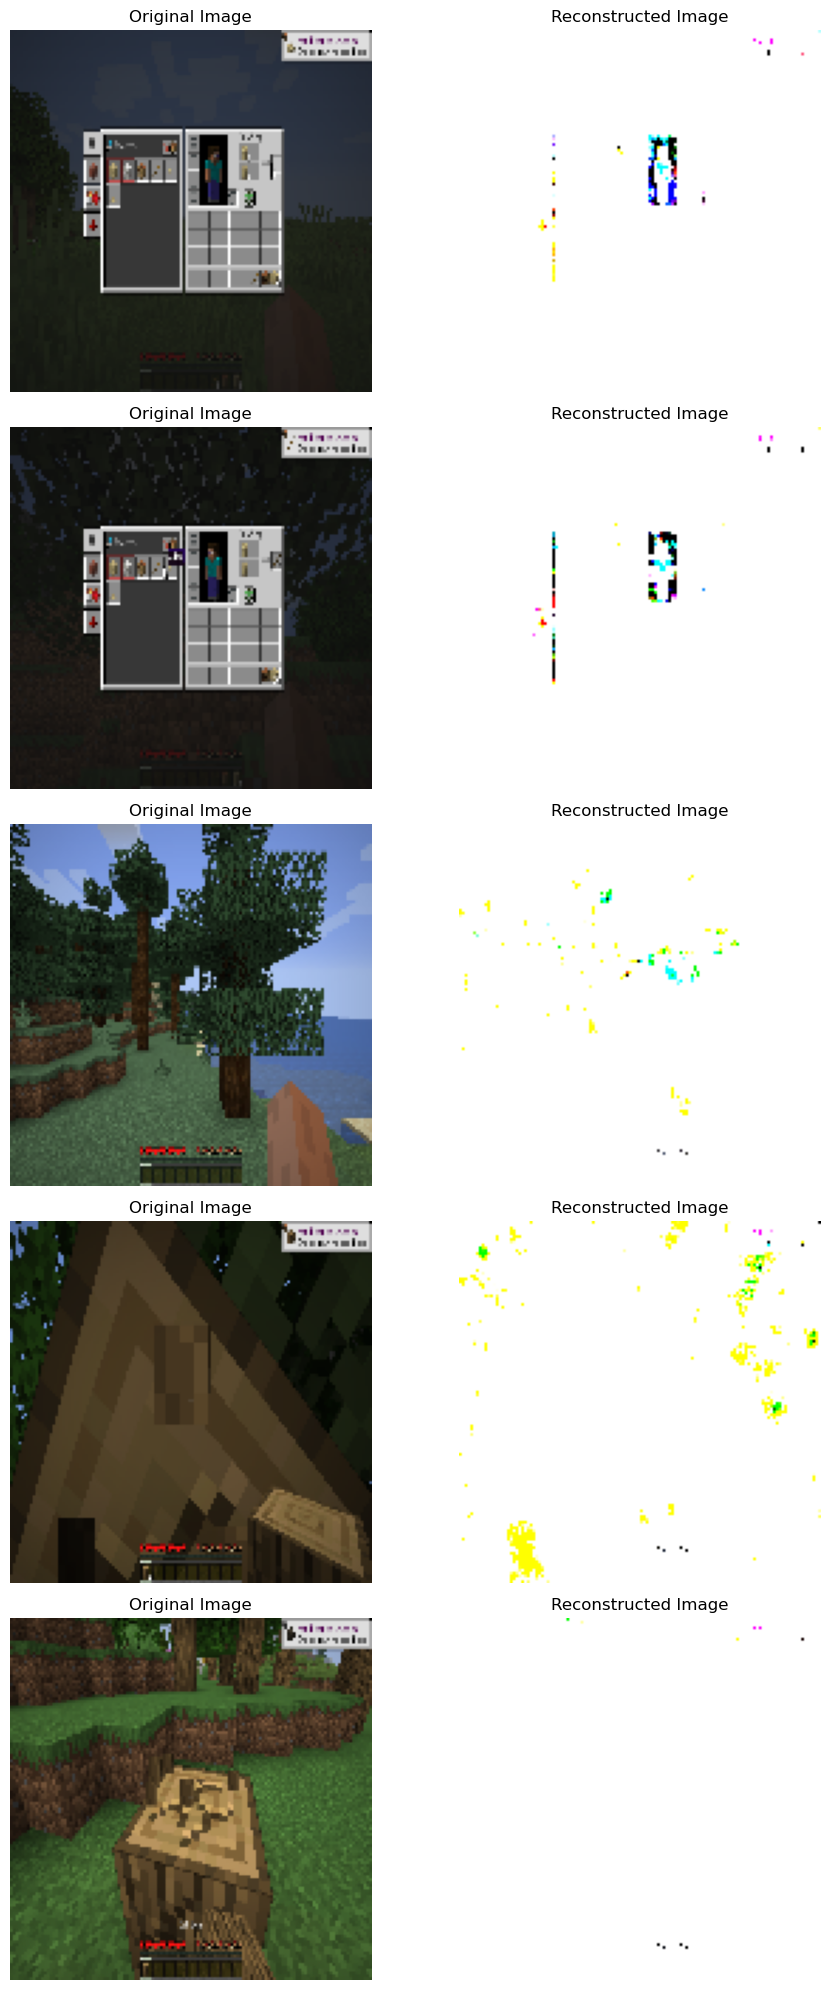

In [13]:
#Choose 5 random files in numpy_files
import random
random_files = random.sample(numpy_files, 5)

og_imgs = []
reconstructed_imgs = []

for file_ in random_files:
    data = np.load(file_, allow_pickle=True)
    #Choose a random index from 1 to the length of the data
    random_index = random.randint(1, len(data))

    img = data[random_index]['image']
    pca_image = pca.transform([img.flatten()])[0]

    reconstructed_img = pca.inverse_transform(pca_image)
    reconstructed_img = reconstructed_img.reshape(128, 128, 3)

    og_imgs.append(img)
    reconstructed_imgs.append(reconstructed_img)


#Plot the original images and reconstructed images side by side and save as pdf 
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

for i in range(5):
    ax[i, 0].imshow(og_imgs[i])
    ax[i, 0].set_title("Original Image")
    ax[i, 0].axis('off')

    ax[i, 1].imshow(reconstructed_imgs[i])
    ax[i, 1].set_title("Reconstructed Image")
    ax[i, 1].axis('off')

plt.tight_layout()
plt.savefig("Data/make_wooden_pickaxe/original_vs_reconstructed_images_2.pdf")
plt.show()